In [1]:
#!pip install pandas_profiling
#!pip install spacy
#!python -m spacy download en_core_web_sm
#!pip install pandas

#!pip install sklearn
#!pip install CatBoost
#!pip install tqdm
#!pip install torch
#!pip install transformers
#!pip install numpy scipy scikit-learn

_______________________________________________________
# Предсказание зарплаты по данным резюме
____________________________________________________

## Часть 1.

**Преамбула:** 

В данной работе не ставила цель достичь определенных показателей качества модели. Базовая логика по подбору гиперпараметров и пр. присутствует и все. Причины в тексте будут :)<br> 

In [1]:
import pandas as pd
import numpy as np

#import pandas_profiling

import spacy
import pickle
import transformers as ppb

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm, notebook

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from catboost import Pool, CatBoostRegressor

Читаем смотрим

In [4]:
tqdm.pandas()
RAND = sum(ord(x) for x in 'NEVER SURRENDER')

In [6]:
df = pd.read_csv('~/Загрузки/Train_rev1.csv', index_col=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244768 entries, 12612628 to 72705235
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Title               244767 non-null  object
 1   FullDescription     244768 non-null  object
 2   LocationRaw         244768 non-null  object
 3   LocationNormalized  244768 non-null  object
 4   ContractType        65442 non-null   object
 5   ContractTime        180863 non-null  object
 6   Company             212338 non-null  object
 7   Category            244768 non-null  object
 8   SalaryRaw           244768 non-null  object
 9   SalaryNormalized    244768 non-null  int64 
 10  SourceName          244767 non-null  object
dtypes: int64(1), object(10)
memory usage: 22.4+ MB


In [7]:
# snaaaaake case
df.columns = df.columns.str.replace('(.)([A-Z])', r'\1_\2', regex=True).str.lower()

_____________________


Кусок без гугл колаба, предварительная разведка на локальном компе.

In [8]:
df_mini = df.sample(20_000, random_state=RAND).reset_index(drop=True)

In [7]:
#это уберу пока. долгий и много места занимает, но посмотреть полезно :)
#df_mini.profile_report()

Точного задания нет, так что немного допущений тут :)

Вообще по результатам тестирований на полном сете "source_name" вполне себе вносил вклад в результат, но будем считать, что в данном случае это будет технической информацией, которой не будет в "реальном" задании. Хехе.

Теортетически, влияние source_name можно объяснить локацией и спецификой сайтов. :) Возможно обычное влияние количества пиратов на глобальное потепление, ложная корреляция.

Таким образом удаляем его, raw-столбцы и title(тайтл по принципу обработки аналогичен дескрипу, пояснение чуть ниже будет).

In [7]:
drop_col = ['title', 'location_raw', 'salary_raw', 'source_name']

In [8]:
df_mini = df_mini.drop(columns=drop_col)

В теории можно попробовать спарсить пропущенные значения из описания, вдруг остались. Но время сильно ограничено, так что не останавливаюсь на этом и просто заполняю на 'Unknown' :) Пока что сойдет.

Да и тут вообще пока что ничего не делаю с параметрами, хотя проблемы вырисовываются, дальше будет.

In [9]:
fill_subset = ['contract_type', 'contract_time', 'company']

In [10]:
df_mini[fill_subset] = df_mini[fill_subset].fillna('Unknown')

По профайлингу заметно, что целевой рапределен не нормально

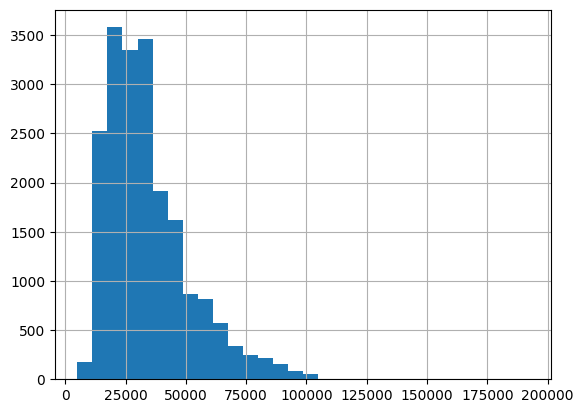

In [12]:
df_mini['salary_normalized'].hist(bins=30);

Для нормализации можно использовать логарифмирование:

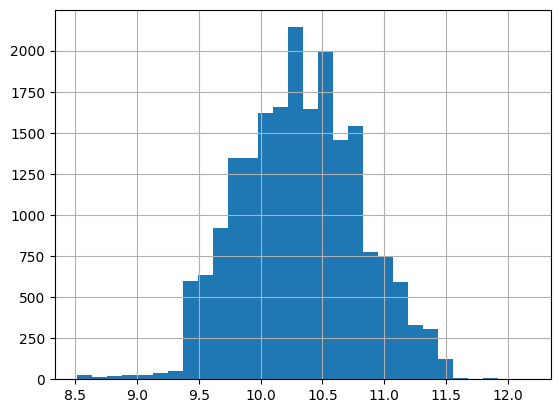

In [14]:
np.log1p(df_mini['salary_normalized']).hist(bins=30);

Так выглядит лучше, буду проверять оба варианта целевого
________________________________


Описание (full_description) тоже чищу минимально, только самое заметное убирается.

(ссылки вроде так, полноценно не тестировала)

In [11]:
%%time
#http https www
df_mini['full_description'] = df_mini['full_description'].str.replace(r'((https?:\/\/)|w{3}).*?( |$)',' ', regex=True)
df_mini['full_description'] = (df_mini['full_description'].str.replace(r'[^A-Za-z\']',' ', regex=True)
                                                          .str.lower()
                                                          .str.strip()
)
df_mini['full_description'] = df_mini['full_description'].str.replace(r'\W{2,}',' ', regex=True)

CPU times: user 4.39 s, sys: 34.8 ms, total: 4.42 s
Wall time: 4.43 s


Лемматизация. 

In [13]:
%%time
try:
    clear_text = pd.read_csv('data/clr_full_descr.csv')['full_description']
    df_mini['clear_description'] = clear_text
except:
    nlp = spacy.load('en_core_web_sm', disable=['parser'])
    #lemma and clear stop 
    clear_text = (df_mini['full_description'].progress_apply(lambda row: 
                                                             ' '.join([w.lemma_ for w in nlp(row) if not w.is_stop]))
    )
    clear_text.to_csv('data/clr_full_descr.csv')

df_mini['clear_description'] = clear_text

100%|█████████████████████████████████████████████████████████| 20000/20000 [12:25<00:00, 26.82it/s]


CPU times: user 12min 23s, sys: 2.65 s, total: 12min 26s
Wall time: 12min 27s


Выборки, валидационной достаточно

In [14]:
mini_train, mini_valid = train_test_split(df_mini, test_size=0.1, random_state=RAND)
print(mini_train.shape)
print(mini_valid.shape)

(18000, 8)
(2000, 8)


In [15]:
del df_mini

_________________________________________
Быструю разведку делаю на CatBoost на необработанных данных.

In [16]:
catboost_params = {
    'iterations': 1000,
    'eval_metric': 'RMSE',
    'verbose': 250,
    'random_state': RAND,
    'depth': 4,
    'learning_rate': 0.1
}

Тут можно и лемматизированный текст использовать, в прицнипе, но пусть уж почти полностью raw будет, с минимальной очисткой который.

In [18]:
X_train = mini_train.drop(['salary_normalized','clear_description'], axis=1)
y_train = mini_train['salary_normalized']
X_val = mini_valid.drop(['salary_normalized','clear_description'], axis=1)
y_val = mini_valid['salary_normalized']

In [19]:
text_features = ['full_description']
cat_features = list(X_train.columns)

In [20]:
train_pool = Pool(
    X_train, 
    y_train, 
    cat_features=cat_features, 
    text_features=text_features
)
val_pool = Pool(
    X_val, 
    y_val, 
    cat_features=cat_features, 
    text_features=text_features
)

Обучаем модель, запихиваем в файл. Ну, или достаем, если она там есть :)

In [21]:
try:
    #load from cat file
    model = CatBoostRegressor()
    model.load_model('models/catboost_model.bin')
except:
    model = CatBoostRegressor(**catboost_params, task_type="GPU")
    model.fit(train_pool, eval_set=val_pool, plot=True)
    model.save_model('models/catboost_model.bin')
    #RMSE
    model.best_score_

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 17072.2158445	test: 17160.7390274	best: 17160.7390274 (0)	total: 43.1ms	remaining: 43.1s
250:	learn: 11618.0165988	test: 11874.4131240	best: 11874.4131240 (250)	total: 7.41s	remaining: 22.1s
500:	learn: 10841.3808715	test: 11511.3304267	best: 11511.3304267 (500)	total: 14.4s	remaining: 14.4s
750:	learn: 10321.4534639	test: 11350.2616964	best: 11350.2616964 (750)	total: 21.5s	remaining: 7.12s
999:	learn: 9920.6152985	test: 11254.3172928	best: 11252.1202809 (995)	total: 28.3s	remaining: 0us
bestTest = 11252.12028
bestIteration = 995
Shrink model to first 996 iterations.


In [22]:
model.score(val_pool)

0.5863956577144197

In [23]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,full_description,67.106363
1,category,12.241689
2,location_normalized,8.496232
3,contract_time,5.912191
4,company,3.880735
5,contract_type,2.362790


In [22]:
#%whos

In [24]:
del train_pool, val_pool, model, catboost_params, clear_text, drop_col, fill_subset

_______________________________________
Вот этот момент отдельно обозначу.

В планах модельку упихать в докер и отправить на удаленный сервер. Он слабенький и там еще всякое запущено, так что пытаюсь максимально все урезать в плане количества. Чтоб нормально обрабатывался вход и нормально работала модель.

В принципе, основная логика все равно останется, а Пайплайны вполне позволят спокойно добавлять. 


Отсюда оставляем только 3 параметра по 'Importances'. 

full_description - тестовый, обработается distilbert

остальные два категориальные(на полной выборке смотрим)

In [25]:
locations = df['location_normalized'].value_counts()
locations

UK                    41093
London                30522
South East London     11713
The City               6678
Manchester             3516
                      ...  
Oldbrook                  1
Berrycroft                1
Pinchbeck                 1
Peasedown St. John        1
Temple                    1
Name: location_normalized, Length: 2732, dtype: int64

In [26]:
sum(locations < 10)

1721

Есть достаточно большое количество локаций, где объявлений менее 10, оно не особо показательно (возможно, можно и куда больше 10 брать). В теории их можно было объединить и сделать типа Other. Но все равно остается достаточно жЫрненький признак по количеству уникальных. 

(забегая вперед, чуть дальше будет переделана обработка  :) тут так останется)<br>
Поэтому для проекта беру еще одну категорию, пусть будет по количеству объявлений в локациях - big, middle, few.

In [27]:
try:
    #load dict
    with open('data/location_dict.pkl', 'rb') as f:
        location_dict = pickle.load(f)
except:
    location_dict = {}
    location_dict.update({key: 'big' for key in locations[locations > 10_000].index})
    location_dict.update({key: 'middle' for key in locations[(locations<10_000) & (locations>670)].index})
    #save dict. name of location for big and middle. all another is few
    with open('data/location_dict.pkl', 'wb') as f:
        pickle.dump(location_dict, f)

In [29]:
def get_location_category(loc_: str) -> str:
    return location_dict.get(loc_,'few')

mini_train['location_category'] = mini_train['location_normalized'].apply(get_location_category)
mini_valid['location_category'] = mini_valid['location_normalized'].apply(get_location_category)

__________________
Вторая. Category

In [30]:
df['category'].value_counts()

IT Jobs                             38483
Engineering Jobs                    25174
Accounting & Finance Jobs           21846
Healthcare & Nursing Jobs           21076
Sales Jobs                          17272
Other/General Jobs                  17055
Teaching Jobs                       12637
Hospitality & Catering Jobs         11351
PR, Advertising & Marketing Jobs     8854
Trade & Construction Jobs            8837
HR & Recruitment Jobs                7713
Admin Jobs                           7614
Retail Jobs                          6584
Customer Services Jobs               6063
Legal Jobs                           3939
Manufacturing Jobs                   3765
Logistics & Warehouse Jobs           3633
Social work Jobs                     3455
Consultancy Jobs                     3263
Travel Jobs                          3126
Scientific & QA Jobs                 2489
Charity & Voluntary Jobs             2332
Energy, Oil & Gas Jobs               2255
Creative & Design Jobs            

Тоже достаточно много. Но неплохо распределены. Пока что с этим признаком ничего не делаю

_____________________
Преобразование столбиков. Тут опять поехал тест на мини-датафрейме

In [31]:
result_features = ['clear_description', 'location_category', 'category']
cat_features = ['location_category', 'category']

In [32]:
#рубрика ЭЭЭЭЭКСПЕРИМЕНТЫ. 
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist')),
    #infrequent_if_exist Changed in version 1.1
])

#last version ----> bert, this unused, but saved
text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), #max_features=10_000
])


preprocessor = ColumnTransformer([
   # ('text', text_pipe, 'clear_description'),
    ('cat', cat_pipe, cat_features)],
    remainder='drop')

#unused
final_pipe = Pipeline([
    ('prep', preprocessor)#,
   # ('pca', TruncatedSVD(n_components=300, random_state=RAND))
])

In [33]:
try:
    #load 
    with open("models/learned_pipe.pkl", "rb") as f:
        learned_pipe = pickle.load(f)
except:
    learned_pipe = preprocessor.fit(mini_train)
    #save 
    with open("models/learned_pipe.pkl", "wb") as f:
        pickle.dump(learned_pipe, f)

Эта часть только для признаков локации и категории.

In [34]:
train_cat_features = learned_pipe.transform(mini_train)
val_cat_features =  learned_pipe.transform(mini_valid)

Переезд на колаб :) Локальный не особо хотел обрабатывать Берт даже на небольшой.